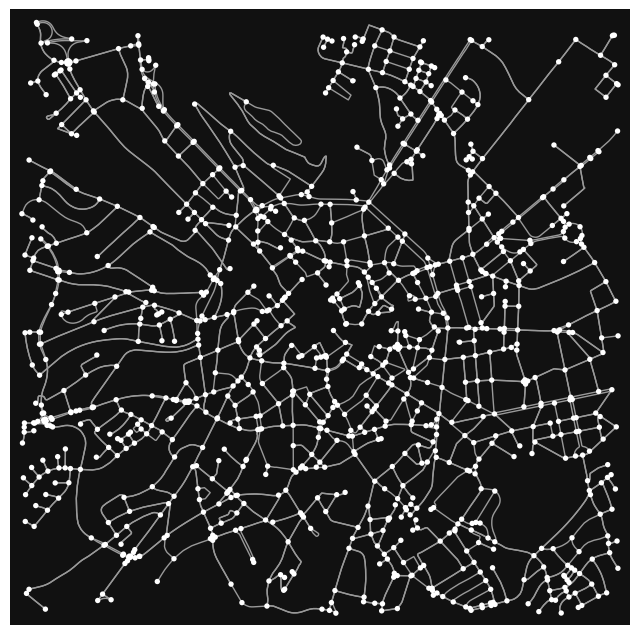

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
import simcronomicon
import sklearn
import networkx as nx
from pyproj import Proj, transform

import osmnx as ox
import matplotlib.pyplot as plt


point = 50.7753, 6.0839
G = ox.graph.graph_from_point(point, network_type="drive", dist=2000)


ox.plot_graph(G)

In [4]:
# Latitude and Longitude of your point (Aachen, Germany as an example)
latitude, longitude = 50.7753, 6.0839

# Calculate UTM zone based on the longitude
utm_zone = int((point[1] + 180) / 6) + 1
# Determine if it's in the northern or southern hemisphere
hemisphere = 'north' if point[0] >= 0 else 'south'

# Create the EPSG code for UTM (using the UTM zone and hemisphere)
epsg_code = f"326{utm_zone}" if hemisphere == 'north' else f"327{utm_zone}"
print(epsg_code)

32632


In [5]:
tags = {"building": True}
G_projected = ox.project_graph(G)

buildings = ox.features.features_from_point(point, tags, 2000)
buildings = buildings.to_crs(epsg=epsg_code)
buildings['centroid'] = buildings.centroid
buildings['nearest_node'] = buildings['centroid'].apply(
    lambda p: ox.distance.nearest_nodes(G_projected, p.x, p.y)
)

#for _, row in buildings.iterrows():
#    building_type = row.get('building', 'unknown')
#    node_id = row['nearest_node']
#    if building_type == 'clinic' or building_type == 'hospital':
#        print(f"Building type: {building_type} → Nearest node: {node_id}")


In [ ]:
def classify_place(row):
    b = str(row.get("building", "")).lower()
    a = str(row.get("amenity", "")).lower()
    l = str(row.get("landuse", "")).lower()
    h = str(row.get("healthcare", "")).lower()
    s = str(row.get("shop", "")).lower()
    e = str(row.get("emergency", "")).lower()

    # Accommodation classification
    if b in ['residential', 'apartments', 'house', 'detached', 'dormitory', 'terrace', 'allotment_house', 'bungalow', 'semidetached_house', 'hut']:
        return 'accommodation'
    
    # Healthcare classification
    elif b in ['hospital', 'dentist'] or \
         h in ['hospital', 'clinic', 'doctor', 'doctors', 'pharmacy', 'laboratory'] or \
         a in ['hospital', 'clinic', 'doctors', 'pharmacy', 'dentist'] or \
         s in ['medical_supply', 'hearing_aids'] or \
         e == 'yes':
        return 'healthcare_facility'
    
    # Commercial classification
    elif b in ['commercial', 'retail', 'supermarket', 'shop', 'service', 'sports_centre'] or \
         a in ['restaurant', 'bar', 'cafe', 'bank', 'fast_food'] or \
         l in ['commercial']:
        return 'commercial'
    
    # Workplace classification (universities, offices, factories)
    elif b in ['office', 'factory', 'industrial', 'government'] or \
         a in ['office', 'factory', 'industry'] or \
         l in ['industrial', 'office']:
        return 'workplace'
    
    # Education classification
    elif b in ['school', 'university', 'kindergarten'] or \
         a in ['university', 'kindergarten']:
        return 'education'
    
    elif b in ['chapel', 'church', 'temple', 'mosque', 'synagogue'] or \
         a in ['chapel', 'church', 'temple', 'mosque', 'synagogue'] or \
         l in ['religious']:
        return 'religious'
    
    else:
        return 'other'

In [11]:
# Step 5: Apply classification
buildings['place_type'] = buildings.apply(classify_place, axis=1)

# Step 6: Annotate nodes with place_type
place_type_map = buildings.set_index('nearest_node')['place_type'].to_dict()
nx.set_node_attributes(G_projected, place_type_map, 'place_type')

# Step 7: Remove nodes with unknown type ('other')
nodes_to_keep = [n for n, d in G_projected.nodes(data=True) if d.get('place_type') in ['accommodation', 'healthcare_facility', 'commercial']]
G_filtered = G_projected.subgraph(nodes_to_keep).copy()
#ox.plot_graph(G_filtered)

building:  garage
amenity:  nan
landuse:  
building:  garage
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  hut
amenity:  nan
landuse:  
building:  bunker
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  social_facility
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  courthouse
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  monastery
landuse:  
building:  yes
amenity:  social_facility
landuse:  
building:  stadium
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  public
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  yes
amenity:  monastery
landuse:  
building:  yes
amenity:  nan
landuse:  
building:  public
ame

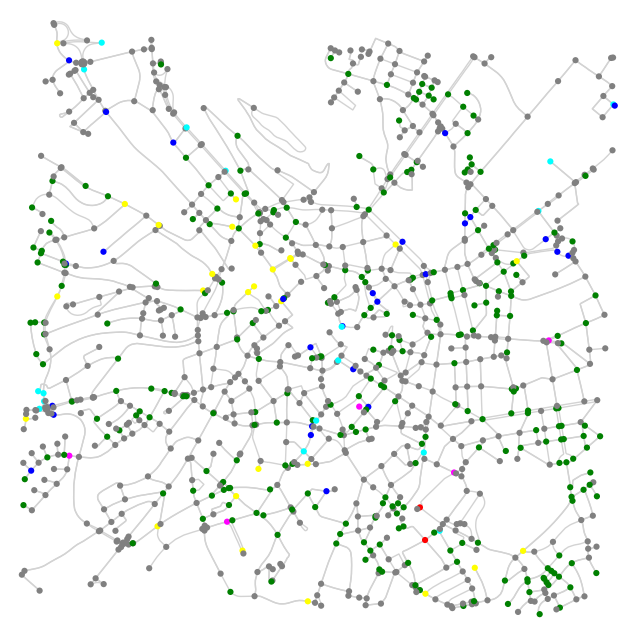

In [12]:
node_colors = []
for node, data in G_projected.nodes(data=True):
    if data.get("place_type") == "healthcare_facility":
        node_colors.append("red")         # Hospital → red
    elif data.get("place_type") == "commercial":
        node_colors.append("blue")        # Commercial → blue
    elif data.get("place_type") == "accommodation":
        node_colors.append("green")       # Accommodation → green
    elif data.get("place_type") == "workplace":
        node_colors.append("cyan")
    elif data.get("place_type") == "education":
        node_colors.append("yellow")
    elif data.get("place_type") == "religious":
        node_colors.append("magenta")
    else:
        node_colors.append("grey")

# Plot with custom node colors
fig, ax = ox.plot_graph(
    G_projected,
    node_color=node_colors,
    node_size=20,
    edge_color="lightgray",
    bgcolor="white",
)

# As we can see here. Luisenhospital is missing.... nothing can be done about that.

In [13]:
from itertools import combinations

G_simple = nx.Graph()
# Create mapping from original to new integer IDs
old_nodes = list(G_filtered.nodes)
id_map = {old_id: new_id for new_id, old_id in enumerate(old_nodes)}
accommodation_node_ids = set()


# Add nodes with new IDs and preserve place_type
for old_id, new_id in id_map.items():
    place_type = G_filtered.nodes[old_id].get('place_type', 'unknown')
    if place_type == 'accommodation':
        accommodation_node_ids.add(new_id)
    G_simple.add_node(new_id, place_type=place_type, folks=[])

# Use G_projected (fully connected) to calculate shortest paths
for id1, id2 in combinations(old_nodes, 2):
    try:
        # Compute shortest path length in full graph
        dist = nx.shortest_path_length(G_projected, source=id1, target=id2, weight='length')
        G_simple.add_edge(id_map[id1], id_map[id2], weight=dist)
    except nx.NetworkXNoPath:
        # Skip if no path exists
        continue
print(G_simple.nodes[1])

{'place_type': 'commercial', 'folks': []}


In [14]:
for u, v, data in G_simple.edges(data=True):
    print(f"Edge from {u} to {v}, weight = {data['weight']}")

Edge from 0 to 1, weight = 297.2098859471651
Edge from 0 to 2, weight = 343.07380902224094
Edge from 0 to 3, weight = 410.33637950796674
Edge from 0 to 4, weight = 2613.7129915922933
Edge from 0 to 5, weight = 2750.6481650819524
Edge from 0 to 6, weight = 2340.9823003726915
Edge from 0 to 7, weight = 359.08360733921944
Edge from 0 to 8, weight = 2492.8268046743856
Edge from 0 to 9, weight = 3569.126553200847
Edge from 0 to 10, weight = 2953.060081155104
Edge from 0 to 11, weight = 2845.6647527544797
Edge from 0 to 12, weight = 2570.5818246592835
Edge from 0 to 13, weight = 2972.84677566887
Edge from 0 to 14, weight = 2981.0728576094702
Edge from 0 to 15, weight = 354.184730490433
Edge from 0 to 16, weight = 445.7907368259877
Edge from 0 to 17, weight = 367.3369813652423
Edge from 0 to 18, weight = 336.2364698935718
Edge from 0 to 19, weight = 112.60166903589004
Edge from 0 to 20, weight = 1336.6174815328293
Edge from 0 to 21, weight = 1401.0733256667247
Edge from 0 to 22, weight = 1440